In [1]:
import glob
import os
import json
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

# Your read_json_and_get_boxes function here
def read_json_and_get_boxes(json_file_path):
    """
    Reads a JSON file and returns a dictionary with filenames as keys and bounding box coordinates as values.
    """
    # Initialize an empty dictionary to store the results
    bounding_boxes = {}
    
    # Load the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)
        
    # Loop through each entry in the JSON file
    for key, value in data.items():
        filename = value['filename']
        regions = value['regions']
        
        # Extract the bounding boxes
        boxes = []
        for region in regions:
            shape_attributes = region['shape_attributes']
            x = shape_attributes['x']
            y = shape_attributes['y']
            width = shape_attributes['width']
            height = shape_attributes['height']
            boxes.append([x, y, width, height])
        
        # Add to the dictionary
        bounding_boxes[filename] = boxes
    
    return bounding_boxes

# Directory path to your dataset
dataset_dir = os.path.normpath("C:/Users/USER/Downloads/brain_tumor_dataset")

# Path to the JSON file
json_file_path = "C:/Users/USER/Downloads/brain_tumor_dataset_annotations.json"

# Read bounding boxes from the JSON file
bounding_boxes = read_json_and_get_boxes(json_file_path)

# Get a list of all image file paths
image_paths = glob.glob(os.path.normpath(f"{dataset_dir}/**/*.jpg"), recursive=True)

# Labels names
image_names = [x.split("\\")[-1] for x in image_paths]
image_names = pd.DataFrame(image_names, columns=['Types'])

# Initialize LabelBinarizer
lb = LabelBinarizer()

# Fit and transform the class labels
transformed_labels = lb.fit_transform(image_names['Types'])

# Adding One-Hot Encoded columns to the DataFrame with descriptive column names
for i, class_name in enumerate(lb.classes_):
    image_names[class_name] = transformed_labels[:, i]

# Optionally, if you want to see the DataFrame
image_names


C:\Users\USER\AppData\Local\Temp\ipykernel_16448\2061781727.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  image_names[class_name] = transformed_labels[:, i]
C:\Users\USER\AppData\Local\Temp\ipykernel_16448\2061781727.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  image_names[class_name] = transformed_labels[:, i]
C:\Users\USER\AppData\Local\Temp\ipykernel_16448\2061781727.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

,Types,10 no.jpg,11 no.jpg,12 no.jpg,13 no.jpg,14 no.jpg,15 no.jpg,17 no.jpg,18 no.jpg,19 no.jpg,...,no 90.jpg,no 92.jpg,no 923.jpg,no 94.jpg,no 95.jpg,no 96.jpg,no 97.jpg,no 98.jpg,no 99.jpg,no.jpg
0,10 no.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11 no.jpg,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12 no.jpg,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13 no.jpg,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14 no.jpg,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,Y95.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,Y96.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,Y97.JPG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,Y98.JPG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
def load_images_and_boxes(image_paths, bounding_boxes):
    """
    Load images and their corresponding bounding boxes from given file paths into TensorFlow tensors.

    Parameters:
    - image_paths: List of file paths to images.
    - bounding_boxes: Dictionary containing bounding box coordinates for each image filename.
    
    Returns:
    - images: List of loaded images as TensorFlow tensors.
    - boxes: List of bounding boxes corresponding to the images.
    """
    images = []
    boxes = []
    for path in image_paths:
        image_raw = tf.io.read_file(path)
        try:
            image = tf.image.decode_image(image_raw)
            images.append(image)
            filename = os.path.basename(path)
            if filename in bounding_boxes:
                boxes.append(bounding_boxes[filename])
            else:
                # Empty list for images without bounding boxes
                boxes.append([])
        except:
            print(f"Warning: Could not read image from {path}")
    return images, boxes

# Load images and their corresponding bounding boxes
loaded_images_tf, loaded_boxes = load_images_and_boxes(image_paths, bounding_boxes)

# Optionally, if you want to see the number of images and boxes loaded and the shape of the first image
print(f"Number of images loaded: {len(loaded_images_tf)}")
print(f"Number of boxes loaded: {len(loaded_boxes)}")
if len(loaded_images_tf) > 0:
    print(f"Shape of the first image: {loaded_images_tf[0].shape}")
if len(loaded_boxes) > 0:
    print(f"Bounding boxes for the first image: {loaded_boxes[0]}")


Number of images loaded: 245
Number of boxes loaded: 245
Shape of the first image: (201, 173, 3)
Bounding boxes for the first image: []


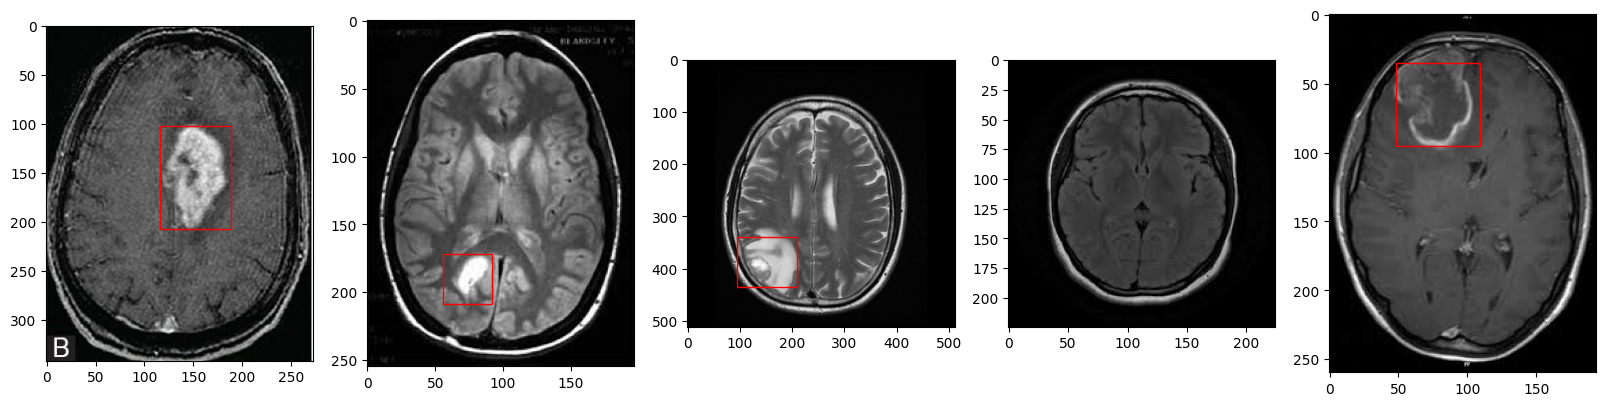

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def show_random_images_with_boxes(images, boxes, num_samples=5):
    """
    Display randomly selected images along with their bounding boxes.
    
    Parameters:
    - images: List of image tensors.
    - boxes: List of bounding boxes for each image.
    - num_samples: Number of random samples to display.
    """
    if len(images) < num_samples:
        print("Number of samples requested is greater than the total number of images.")
        return
    
    # Randomly select 'num_samples' indices
    random_indices = random.sample(range(len(images)), num_samples)
    
    # Fetch the images and boxes for the randomly selected indices
    random_images = [images[i] for i in random_indices]
    random_boxes = [boxes[i] for i in random_indices]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))
    
    for ax, img, box in zip(axes, random_images, random_boxes):
        ax.imshow(img.numpy())
        
        # If the image has bounding boxes, draw them
        if len(box) > 0:
            for b in box:
                x, y, width, height = b
                rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
        
        ax.axis('on')
    
    plt.show()

# Show 5 random samples
show_random_images_with_boxes(loaded_images_tf, loaded_boxes, num_samples=5)


In [4]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for bounding box regression and classification
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)  # Add Batch Normalization
bbox_output = Dense(4, activation='linear', name='bounding_box')(x)
x = BatchNormalization()(x)  # Add Batch Normalization
class_output = Dense(1, activation='sigmoid', name='class_output')(x)

# Create the final model
custom_model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

# Learning rate scheduling
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Compile the model
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                     loss={'bounding_box': 'mean_squared_error', 'class_output': 'binary_crossentropy'},
                     metrics={'class_output': 'accuracy'})

# Summary of the model architecture
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np


# Resize images and standardize to 3 channels (RGB)
resize_shape = (224, 224)
standardized_images = []
standardized_boxes = np.zeros((len(loaded_boxes), 4))

for i, img in enumerate(loaded_images_tf):
    original_shape = tf.shape(img).numpy()[:2]
    height_scale = resize_shape[0] / original_shape[0]
    width_scale = resize_shape[1] / original_shape[1]
    
    img_resized = tf.image.resize(img, resize_shape)
    if img_resized.shape[-1] == 1:
        img_rgb = tf.image.grayscale_to_rgb(img_resized)
    elif img_resized.shape[-1] == 4:
        img_rgb = img_resized[..., :3]
    else:
        img_rgb = img_resized

    # Adjust bounding boxes
    if len(loaded_boxes[i]) > 0:
        box = loaded_boxes[i][0]
        adjusted_box = [box[0]*width_scale, box[1]*height_scale, box[2]*width_scale, box[3]*height_scale]
        standardized_boxes[i] = adjusted_box

    standardized_images.append(img_rgb)

# Stack and normalize images
image_tensor = tf.stack(standardized_images)
image_normalized = image_tensor / 255.0

# Prepare class labels (assuming binary classification)
class_labels = np.array([1 if len(box) > 0 else 0 for box in loaded_boxes])

# Train-validation split
image_train, image_val, box_train, box_val, label_train, label_val = train_test_split(
    image_normalized.numpy(), standardized_boxes, class_labels, test_size=0.2, random_state=42
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((image_train, {'bounding_box': box_train, 'class_output': label_train}))
val_dataset = tf.data.Dataset.from_tensor_slices((image_val, {'bounding_box': box_val, 'class_output': label_val}))

# Batch and shuffle
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(buffer_size=len(image_train)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [6]:
# Compile the custom model
custom_model.compile(optimizer='adam', 
                     loss={'bounding_box': 'mean_squared_error', 'class_output': 'binary_crossentropy'},
                     metrics={'class_output': 'accuracy'})


In [7]:
# Train the model
EPOCHS = 300

history = custom_model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=EPOCHS,
                           verbose=1)


Epoch 1/300
4/4 [==============================] - 13s 2s/step - loss: 3740.1521 - bounding_box_loss: 3739.4778 - class_output_loss: 0.6746 - class_output_accuracy: 0.6531 - val_loss: 3887.5017 - val_bounding_box_loss: 3886.8496 - val_class_output_loss: 0.6517 - val_class_output_accuracy: 0.6122
Epoch 2/300
4/4 [==============================] - 1s 129ms/step - loss: 3412.4387 - bounding_box_loss: 3412.1853 - class_output_loss: 0.2538 - class_output_accuracy: 0.8929 - val_loss: 3724.8889 - val_bounding_box_loss: 3724.3440 - val_class_output_loss: 0.5452 - val_class_output_accuracy: 0.6531
Epoch 3/300
4/4 [==============================] - 1s 136ms/step - loss: 3186.0623 - bounding_box_loss: 3185.9216 - class_output_loss: 0.1403 - class_output_accuracy: 0.9439 - val_loss: 3562.6926 - val_bounding_box_loss: 3562.1575 - val_class_output_loss: 0.5351 - val_class_output_accuracy: 0.6735
Epoch 4/300
4/4 [==============================] - 1s 128ms/step - loss: 2978.5396 - bounding_box_loss: 2

4/4 [==============================] - 1s 130ms/step - loss: 310.1686 - bounding_box_loss: 310.1212 - class_output_loss: 0.0474 - class_output_accuracy: 0.9898 - val_loss: 1437.2671 - val_bounding_box_loss: 1435.4734 - val_class_output_loss: 1.7938 - val_class_output_accuracy: 0.6122
Epoch 29/300
4/4 [==============================] - 1s 129ms/step - loss: 285.9731 - bounding_box_loss: 285.9503 - class_output_loss: 0.0227 - class_output_accuracy: 0.9949 - val_loss: 1420.4014 - val_bounding_box_loss: 1418.6489 - val_class_output_loss: 1.7523 - val_class_output_accuracy: 0.6122
Epoch 30/300
4/4 [==============================] - 1s 132ms/step - loss: 290.7610 - bounding_box_loss: 290.7333 - class_output_loss: 0.0277 - class_output_accuracy: 0.9898 - val_loss: 1402.8845 - val_bounding_box_loss: 1401.1639 - val_class_output_loss: 1.7205 - val_class_output_accuracy: 0.6327
Epoch 31/300
4/4 [==============================] - 1s 132ms/step - loss: 243.7825 - bounding_box_loss: 243.7443 - clas

4/4 [==============================] - 1s 132ms/step - loss: 110.7987 - bounding_box_loss: 110.7965 - class_output_loss: 0.0022 - class_output_accuracy: 1.0000 - val_loss: 1113.5398 - val_bounding_box_loss: 1112.7534 - val_class_output_loss: 0.7864 - val_class_output_accuracy: 0.7959
Epoch 56/300
4/4 [==============================] - 1s 133ms/step - loss: 129.1662 - bounding_box_loss: 129.0657 - class_output_loss: 0.1005 - class_output_accuracy: 0.9847 - val_loss: 1100.3859 - val_bounding_box_loss: 1099.6129 - val_class_output_loss: 0.7730 - val_class_output_accuracy: 0.7959
Epoch 57/300
4/4 [==============================] - 1s 135ms/step - loss: 106.2286 - bounding_box_loss: 106.1971 - class_output_loss: 0.0314 - class_output_accuracy: 0.9796 - val_loss: 1090.5532 - val_bounding_box_loss: 1089.9283 - val_class_output_loss: 0.6249 - val_class_output_accuracy: 0.8367
Epoch 58/300
4/4 [==============================] - 1s 134ms/step - loss: 97.3345 - bounding_box_loss: 97.3305 - class_

Epoch 83/300
4/4 [==============================] - 1s 130ms/step - loss: 50.9662 - bounding_box_loss: 50.9641 - class_output_loss: 0.0021 - class_output_accuracy: 1.0000 - val_loss: 886.1821 - val_bounding_box_loss: 885.6940 - val_class_output_loss: 0.4882 - val_class_output_accuracy: 0.8776
Epoch 84/300
4/4 [==============================] - 1s 131ms/step - loss: 53.4117 - bounding_box_loss: 53.4106 - class_output_loss: 0.0011 - class_output_accuracy: 1.0000 - val_loss: 877.3746 - val_bounding_box_loss: 876.8584 - val_class_output_loss: 0.5163 - val_class_output_accuracy: 0.8776
Epoch 85/300
4/4 [==============================] - 1s 130ms/step - loss: 50.8309 - bounding_box_loss: 50.8260 - class_output_loss: 0.0049 - class_output_accuracy: 1.0000 - val_loss: 865.6337 - val_bounding_box_loss: 865.1219 - val_class_output_loss: 0.5117 - val_class_output_accuracy: 0.8776
Epoch 86/300
4/4 [==============================] - 1s 130ms/step - loss: 71.9945 - bounding_box_loss: 71.9348 - class

Epoch 111/300
4/4 [==============================] - 1s 133ms/step - loss: 48.7007 - bounding_box_loss: 48.6512 - class_output_loss: 0.0495 - class_output_accuracy: 0.9898 - val_loss: 734.9870 - val_bounding_box_loss: 734.5626 - val_class_output_loss: 0.4244 - val_class_output_accuracy: 0.8776
Epoch 112/300
4/4 [==============================] - 1s 131ms/step - loss: 45.2644 - bounding_box_loss: 45.2309 - class_output_loss: 0.0335 - class_output_accuracy: 0.9949 - val_loss: 733.9482 - val_bounding_box_loss: 733.5911 - val_class_output_loss: 0.3571 - val_class_output_accuracy: 0.8571
Epoch 113/300
4/4 [==============================] - 1s 130ms/step - loss: 56.3428 - bounding_box_loss: 56.3036 - class_output_loss: 0.0393 - class_output_accuracy: 0.9898 - val_loss: 727.6808 - val_bounding_box_loss: 727.3616 - val_class_output_loss: 0.3191 - val_class_output_accuracy: 0.8571
Epoch 114/300
4/4 [==============================] - 1s 130ms/step - loss: 69.2517 - bounding_box_loss: 69.2471 - c

Epoch 139/300
4/4 [==============================] - 1s 137ms/step - loss: 30.7077 - bounding_box_loss: 30.7070 - class_output_loss: 6.6613e-04 - class_output_accuracy: 1.0000 - val_loss: 681.3469 - val_bounding_box_loss: 680.6559 - val_class_output_loss: 0.6910 - val_class_output_accuracy: 0.8776
Epoch 140/300
4/4 [==============================] - 1s 137ms/step - loss: 40.0292 - bounding_box_loss: 40.0275 - class_output_loss: 0.0017 - class_output_accuracy: 1.0000 - val_loss: 675.3254 - val_bounding_box_loss: 674.7013 - val_class_output_loss: 0.6241 - val_class_output_accuracy: 0.8776
Epoch 141/300
4/4 [==============================] - 1s 134ms/step - loss: 67.1328 - bounding_box_loss: 66.8996 - class_output_loss: 0.2331 - class_output_accuracy: 0.9898 - val_loss: 672.4445 - val_bounding_box_loss: 671.9169 - val_class_output_loss: 0.5277 - val_class_output_accuracy: 0.8776
Epoch 142/300
4/4 [==============================] - 1s 135ms/step - loss: 45.2635 - bounding_box_loss: 45.2596

Epoch 167/300
4/4 [==============================] - 1s 134ms/step - loss: 25.2503 - bounding_box_loss: 25.2503 - class_output_loss: 3.4803e-05 - class_output_accuracy: 1.0000 - val_loss: 655.8448 - val_bounding_box_loss: 655.1063 - val_class_output_loss: 0.7385 - val_class_output_accuracy: 0.8776
Epoch 168/300
4/4 [==============================] - 1s 135ms/step - loss: 26.7445 - bounding_box_loss: 26.7251 - class_output_loss: 0.0194 - class_output_accuracy: 0.9949 - val_loss: 661.5743 - val_bounding_box_loss: 660.5979 - val_class_output_loss: 0.9764 - val_class_output_accuracy: 0.8776
Epoch 169/300
4/4 [==============================] - 1s 135ms/step - loss: 35.0174 - bounding_box_loss: 35.0134 - class_output_loss: 0.0040 - class_output_accuracy: 1.0000 - val_loss: 669.5294 - val_bounding_box_loss: 668.2756 - val_class_output_loss: 1.2537 - val_class_output_accuracy: 0.8980
Epoch 170/300
4/4 [==============================] - 1s 136ms/step - loss: 38.2489 - bounding_box_loss: 38.1591

Epoch 195/300
4/4 [==============================] - 1s 136ms/step - loss: 37.1160 - bounding_box_loss: 37.1099 - class_output_loss: 0.0061 - class_output_accuracy: 0.9949 - val_loss: 645.6711 - val_bounding_box_loss: 644.4630 - val_class_output_loss: 1.2082 - val_class_output_accuracy: 0.8980
Epoch 196/300
4/4 [==============================] - 1s 135ms/step - loss: 48.2066 - bounding_box_loss: 48.1827 - class_output_loss: 0.0239 - class_output_accuracy: 0.9898 - val_loss: 640.3693 - val_bounding_box_loss: 639.2155 - val_class_output_loss: 1.1538 - val_class_output_accuracy: 0.9184
Epoch 197/300
4/4 [==============================] - 1s 135ms/step - loss: 26.1803 - bounding_box_loss: 26.1802 - class_output_loss: 6.0430e-05 - class_output_accuracy: 1.0000 - val_loss: 644.3003 - val_bounding_box_loss: 643.1475 - val_class_output_loss: 1.1528 - val_class_output_accuracy: 0.9184
Epoch 198/300
4/4 [==============================] - 1s 135ms/step - loss: 45.1472 - bounding_box_loss: 45.1471

Epoch 223/300
4/4 [==============================] - 1s 131ms/step - loss: 26.4684 - bounding_box_loss: 26.4683 - class_output_loss: 6.2816e-05 - class_output_accuracy: 1.0000 - val_loss: 636.5094 - val_bounding_box_loss: 635.8069 - val_class_output_loss: 0.7024 - val_class_output_accuracy: 0.8980
Epoch 224/300
4/4 [==============================] - 1s 131ms/step - loss: 24.4980 - bounding_box_loss: 24.4980 - class_output_loss: 2.5519e-05 - class_output_accuracy: 1.0000 - val_loss: 629.1877 - val_bounding_box_loss: 628.4636 - val_class_output_loss: 0.7241 - val_class_output_accuracy: 0.8980
Epoch 225/300
4/4 [==============================] - 1s 130ms/step - loss: 95.4513 - bounding_box_loss: 95.4504 - class_output_loss: 8.8546e-04 - class_output_accuracy: 1.0000 - val_loss: 622.8804 - val_bounding_box_loss: 622.1456 - val_class_output_loss: 0.7349 - val_class_output_accuracy: 0.9184
Epoch 226/300
4/4 [==============================] - 1s 130ms/step - loss: 22.2898 - bounding_box_loss:

4/4 [==============================] - 1s 134ms/step - loss: 30.5883 - bounding_box_loss: 30.5647 - class_output_loss: 0.0237 - class_output_accuracy: 0.9949 - val_loss: 653.5778 - val_bounding_box_loss: 653.0204 - val_class_output_loss: 0.5573 - val_class_output_accuracy: 0.8980
Epoch 251/300
4/4 [==============================] - 1s 132ms/step - loss: 34.3699 - bounding_box_loss: 34.3684 - class_output_loss: 0.0014 - class_output_accuracy: 1.0000 - val_loss: 649.0378 - val_bounding_box_loss: 648.4388 - val_class_output_loss: 0.5990 - val_class_output_accuracy: 0.8776
Epoch 252/300
4/4 [==============================] - 1s 131ms/step - loss: 54.2572 - bounding_box_loss: 54.2569 - class_output_loss: 3.4817e-04 - class_output_accuracy: 1.0000 - val_loss: 645.0729 - val_bounding_box_loss: 644.4308 - val_class_output_loss: 0.6421 - val_class_output_accuracy: 0.8776
Epoch 253/300
4/4 [==============================] - 1s 131ms/step - loss: 24.9984 - bounding_box_loss: 24.9962 - class_outpu

Epoch 278/300
4/4 [==============================] - 1s 135ms/step - loss: 40.5228 - bounding_box_loss: 40.5214 - class_output_loss: 0.0014 - class_output_accuracy: 1.0000 - val_loss: 632.0201 - val_bounding_box_loss: 631.3269 - val_class_output_loss: 0.6932 - val_class_output_accuracy: 0.9388
Epoch 279/300
4/4 [==============================] - 1s 136ms/step - loss: 42.1419 - bounding_box_loss: 42.1380 - class_output_loss: 0.0039 - class_output_accuracy: 1.0000 - val_loss: 630.6097 - val_bounding_box_loss: 629.8693 - val_class_output_loss: 0.7403 - val_class_output_accuracy: 0.9388
Epoch 280/300
4/4 [==============================] - 1s 135ms/step - loss: 45.1148 - bounding_box_loss: 45.0913 - class_output_loss: 0.0235 - class_output_accuracy: 0.9898 - val_loss: 630.6118 - val_bounding_box_loss: 629.8591 - val_class_output_loss: 0.7526 - val_class_output_accuracy: 0.9388
Epoch 281/300
4/4 [==============================] - 1s 134ms/step - loss: 16.9204 - bounding_box_loss: 16.9176 - c

2/2 [==============================] - 0s 204ms/step


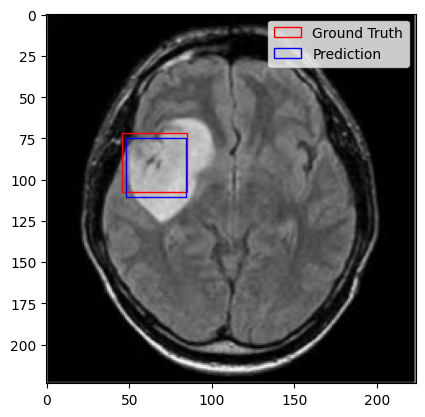

In [14]:
import random
import matplotlib.pyplot as plt

# Function to plot predictions and ground truth
def plot_predictions(image, ground_truth_box, predicted_box):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Plot ground truth box
    gt_rect = plt.Rectangle((ground_truth_box[0], ground_truth_box[1]), ground_truth_box[2], ground_truth_box[3],
                            linewidth=1, edgecolor="r", facecolor="none", label="Ground Truth")
    ax.add_patch(gt_rect)
    
    # Plot predicted box
    pred_rect = plt.Rectangle((predicted_box[0], predicted_box[1]), predicted_box[2], predicted_box[3],
                              linewidth=1, edgecolor="b", facecolor="none", label="Prediction")
    ax.add_patch(pred_rect)
    
    plt.legend()
    plt.show()


# Select a random batch from the training dataset
for batch_images, outputs in train_dataset.shuffle(buffer_size=len(image_train)).take(1):  
    predictions = custom_model.predict(batch_images)
    predicted_boxes = predictions[0]
    predicted_labels = predictions[1]
    
    # Select a random image from this batch
    i = random.randint(0, len(batch_images) - 1)
    
    image = batch_images[i].numpy()
    
    ground_truth_box = outputs['bounding_box'].numpy()[i]
    predicted_box = predicted_boxes[i]
    
    # Plot the ground truth and prediction for this random image
    plot_predictions(image, ground_truth_box, predicted_box)


In [9]:
# Print first 5 items in the bounding_boxes dictionary
first_5_items = {k: bounding_boxes[k] for k in list(bounding_boxes.keys())[:5]}
print("First 5 entries in bounding_boxes:", first_5_items)


First 5 entries in bounding_boxes: {'Y1.jpg': [[11, 75, 86, 69]], 'Y2.jpg': [[52, 56, 53, 58]], 'Y3.jpg': [[148, 143, 49, 42]], 'Y4.jpg': [[46, 72, 39, 36]], 'Y6.jpg': [[345, 640, 104, 108]]}
